Clipping an image, code

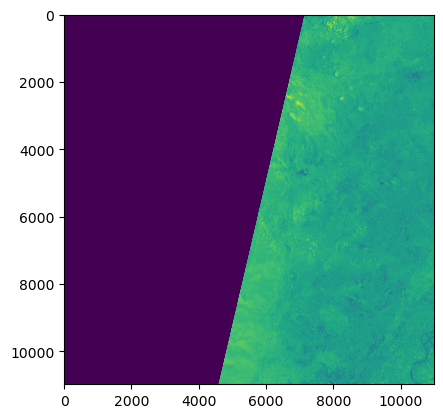

In [14]:
# import our necessary packages
import rasterio # rasterio helps us read the raster image file
from matplotlib import pyplot as plt # pyplot helps us plot/visualize our image data
import numpy as np # numpy helps us scale our underlying band values

# specify file to import
image_file = "T42RUR_20220702T055651_B08.jp2"

# define it as a rasterio object so we can use rasterio functions
my_raster_image = rasterio.open(image_file)

# scale values for display purposes
def scale(band): 
    return band / 150.0

# import our multiband layers - blue, green red
#blue = scale(my_raster_image.read(4))
#green = scale(my_raster_image.read(3))
#red = scale(my_raster_image.read(2))
nir = scale(my_raster_image.read())

# stack them into a single image for a true color composite
my_image = np.dstack((nir))

# show the image using pylot
plt.imshow(my_image)

In [15]:
# get x and y bounds
xmin, ymin, xmax, ymax = my_raster_image.bounds

# Let's get the x and y range first 
x_range = xmax - xmin
y_range = ymax - ymin
print(round(x_range), round(y_range))

print("Initial values are {}, {}, {} and {}".format(
    round(xmin), 
    round(ymin), 
    round(xmax), 
    round(ymax))
)

# Respecify the maximum values to be smaller to get an AoI inside this existing image
xmin = 380000
ymin = 3073890
xmax = 406000
ymax = 3088260


# Check final values
print("Final values are {}, {}, {} and {}".format(
    round(xmin), 
    round(ymin), 
    round(xmax), 
    round(ymax))
)

109800 109800
Initial values are 300000, 2990220, 409800 and 3100020
Final values are 380000, 3073890, 406000 and 3088260


In [16]:
# define the geometry type, which is a polygon  
my_geojson = [{
	"type": "Polygon", 
	"coordinates": [ 
	  [
		[xmin, ymin],
		[xmax, ymin],
		[xmax, ymax],
		[xmin, ymax],
		[xmin, ymin]
	  ],
	]
  }]
my_geojson

[{'type': 'Polygon',
  'coordinates': [[[380000, 3073890],
    [406000, 3073890],
    [406000, 3088260],
    [380000, 3088260],
    [380000, 3073890]]]}]

In [17]:
# Masking is a technique used to clarify dense or detailed map content by having 
# the features of one layer hide, or mask, features of another layer where they overlap
from rasterio.mask import mask

In [18]:
# apply the rasterio mask 
# specify the function needs to crop (via crop=True)
with rasterio.open(image_file) as img:
    clipped_s1, transform = mask(img, my_geojson, crop=True)
    
# view your clipped multiband numpy array
print(clipped_s1)

[[[4392 4372 4264 ... 3534 3517 3656]
  [4343 4302 4234 ... 3540 3536 3501]
  [4329 4246 4253 ... 3556 3571 3518]
  ...
  [4010 4035 4055 ... 3751 3762 3730]
  [4027 4049 4076 ... 3540 3516 3538]
  [4010 4031 4064 ... 3460 3468 3517]]]


In [19]:
# copy the metadata from the original ratserio object
meta = my_raster_image.meta.copy()

# update metadata, and provide the new clipped boundaries
meta.update(
    {
    
        "transform": transform,
        "height":clipped_s1.shape[1],
        "width":clipped_s1.shape[2]
    }
)
print(meta) # show metadata

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 2600, 'height': 1437, 'count': 1, 'crs': CRS.from_epsg(32642), 'transform': Affine(10.0, 0.0, 380000.0,
       0.0, -10.0, 3088260.0)}


In [20]:
# Now we write new image to a GeoTIFF, 'w' is write
with rasterio.open('clipped_Sep_05_RUR_qambar_NIR8.tif', 'w', **meta) as my_writer_object:
    my_writer_object.write(clipped_s1)
    
print('Writing complete')

Writing complete
